by Linh Van NGUYEN

Date: 16/5/2016

### Requirements:
    * sklearn
    * pandas
    * xgboost
    * BeautifulSoup
    * nltk
To install the required package, run this command in the terminal:
    
    sudo pip install -r requirements.txt

Also two following files should be in the same directory:
    * utils.py - some useful functions
        read_textfile(filename, separate): read text from file with given separator
        score_model(model,X,t,cv,scoring): return score of a classifier using cross-validation
        text_to_wordlist(text, remove_stopwords=False): clean and return wordlist from given tweets
    * predict_sentiments.py - function to predict sentiments from given tweets
        predict_singlemodel(tweetsTrain, labelsTrain, tweetsTest): using the best single model 
        predict_singlemodel(tweetsTrain, labelsTrain, tweetsTest): ensemble all models


In [1]:
%matplotlib inline  
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import string
import numpy as np
import pandas as pd
import scipy.sparse

import utils as utils

from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn import svm, cross_validation
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_selection import SelectFromModel

import xgboost as xgb

/home/nguyen/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Part 1: Data exploration

### First look at the data
To start, it is important to look at the data: the fields, size, data type ...
The data given is 6588 tweets of different subjects, classified into 3 categories of sentiments: *positive*, *neural* and *negative*. The problem is to learn from these training samples and propose models that can predict a given tweets to see the sentiment of the person who posted it. 

Data is given in text file. It is more convenient to work with panda dataframe sometime. Sentiments are also converted to 0, 1, 2 for positive, neutral and negative respectively.

In [2]:
df = utils.read_textfile('train-tweets.txt',',')
tweets = df.tweet.values
labels = pd.factorize(df.sentiment)[0]
sentiments = pd.factorize(df.sentiment)[1]

In [3]:
print('Total number of tweets:',len(tweets))
df.head()

('Total number of tweets:', 6588)


,sentiment,tweet
0,positive,Gas by my house hit $3.39!!!! I'm going to Ch...
1,negative,"Theo Walcott is still shit, watch Rafa and Jo..."
2,negative,"its not that I'm a GSP fan, i just hate Nick ..."
3,negative,Iranian general says Israel's Iron Dome can't...
4,positive,with J Davlar 11th. Main rivals are team Pola...


### Clean text and extract words
The original tweets are cleaned to make everything lower case, remove non-letter characters, and remove links. After the cleaning, the function returns a list of words.

In [4]:
print('Sample tweet:%s' % (tweets[100]))
print('Cleaned tweet:%s' % (' '.join(utils.text_to_wordlist(tweets[100], True))))

Sample tweet: Most common nights to order pizza: NYE, Jan 1, day before Thanksgiving, Super Bowl Sunday, Halloween. http://p-bu.mp/msp- 

Cleaned tweet:common nights order pizza nye jan day thanksgiving super bowl sunday halloween


### Extracting features
To build machine learning models for natural language, it is essential to convert text into numeric features. The most common way is to use *Bag-of-word*, which creates a huge sparse matrix of all possible words in the text, then counting the number of each appearance. Another way is *Term-frequency*, which is to normalized version *Bag-of-word*. The *Term Frequency times Inverse Document Frequency* takes into account the words appears many times, which in fact less informative and therefore should take less weights. Further information can be found here:
http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html

Other vectorization such as *Word2Vec* can be studied as well.

In this code, I investigated 3 different ways of vectorization: *Bag-of-word*, *Term Frequency times Inverse Document Frequency*, and stacking version of these two

In [5]:
print CountVectorizer().fit_transform(["Hello Pierre, I am Linh", "Hello Linh, I am Sylvian"]).A
print TfidfVectorizer(use_idf=False).fit_transform(["Hello Pierre, I am Linh", "Hello Linh, I am Sylvian"]).A

[[1 1 1 1 0]
 [1 1 1 0 1]]
[[ 0.5  0.5  0.5  0.5  0. ]
 [ 0.5  0.5  0.5  0.   0.5]]


In [6]:
# join all tweets into one text
texts = []
for tweet in tweets:
    texts.append(" ".join(utils.text_to_wordlist(tweet, False)))
    
# Vectorizing
maxFeatures = 10
vectorizer = CountVectorizer(
    analyzer = 'word',
    tokenizer = None,
    lowercase = True,
    stop_words = None,
    max_features = maxFeatures
)

sampleFeatures = vectorizer.fit_transform(texts).toarray()

dist = np.sum(sampleFeatures, axis=0)
vocab = vectorizer.get_feature_names()

print "Top 10 most frequent words,which is less informative:"
for tag, count in zip(vocab, dist):
    print count, tag

Top 10 most frequent words,which is less informative:
1769 and
1333 at
1569 for
2093 in
1273 is
1664 of
2041 on
5736 the
3030 to
1149 with


In [7]:
# Vectorizing
maxFeatures = 10
tfv = TfidfVectorizer(min_df=3,  max_features=maxFeatures, 
        strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
        ngram_range=(1, 2), use_idf=1,smooth_idf=1,sublinear_tf=1,
        stop_words = 'english')
sampleFeatures = tfv.fit_transform(texts).toarray()
print sampleFeatures

[[ 0.          0.70336456  0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.56616306 ...,  0.          0.          0.        ]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          1.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]]


# Part 2: Various classifiers
Here I investigate the standard classifiers, from naive Bayes, logistic classification, linear SVM to various ensembled version of decision tree such as Random Forest, Extra Tree, ADA boost and very new (and powerful) extreme gradient boosting from *xgboost* package

Model selection and parameter optimization are done using standard k-fold cross validation (stratified version, which equally split the labels) for all three cases of vectorization:
    
    *cross_validataion_CountVectorizer.py: "bag-of-word"
    *cross_validataion_TfidfVectorizer.py: "Term Frequency times Inverse Document Frequency"
    *cross_validataion_CountTfidfVectorizer.py: using joined (stacked) features from the above two

Accuracy of each classifiers are reported for 3 different cases averaging from 10 folds of cross validation

### 1. Bag-of-word: feature vectorized by counting

In [8]:
maxFeatures = 2000
vectorizer = CountVectorizer(
    analyzer = 'word',
    tokenizer = None,
    lowercase = True,
    stop_words = None,
    max_features = maxFeatures
)
      
featuresCountVectorized = vectorizer.fit_transform(texts)    

In [9]:
skfCV = cross_validation.StratifiedKFold(labels, n_folds=10, shuffle=True, random_state=None) # split target equally

clfLR = LogisticRegression(penalty='l2', dual=True, tol=0.0001, C=1, fit_intercept=True, 
                           intercept_scaling=1.0, class_weight=None, random_state=None)
clfNB = MultinomialNB()
clfSGD = SGDClassifier(loss='hinge', penalty='l2', alpha = 3*1e-3, n_iter=5, random_state=42)
clfRF = RandomForestClassifier(n_estimators=250)
clfEXT = ExtraTreesClassifier(n_estimators=300)
clfADA = AdaBoostClassifier(n_estimators=100, learning_rate = 0.75)
clfXGB = xgb.XGBClassifier(objective= 'logistic', nthread=3, silent = 1, seed=8,
                           n_estimators = 400, max_depth = 6, learning_rate = 0.075, 
                           subsample = 0.9, colsample_bytree = 1.0)

print("Accuracy ( LR): %f" % (np.mean(utils.score_model(clfLR ,featuresCountVectorized,labels, 
                                                        cv = skfCV, scoring = "accuracy"))))
print("Accuracy ( NB): %f" % ( np.mean(utils.score_model(clfNB ,featuresCountVectorized,labels, 
                                                         cv = skfCV,scoring = "accuracy"))))
print("Accuracy (SVM): %f" % ( np.mean(utils.score_model(clfSGD,featuresCountVectorized,labels, 
                                                         cv = skfCV,scoring = "accuracy"))))
print("Accuracy ( RF): %f" % ( np.mean(utils.score_model(clfRF ,featuresCountVectorized,labels, 
                                                         cv = skfCV,scoring = "accuracy"))))
print("Accuracy (EXT): %f" % ( np.mean(utils.score_model(clfEXT,featuresCountVectorized,labels, 
                                                         cv = skfCV,scoring = "accuracy"))))
print("Accuracy (ADA): %f" % ( np.mean(utils.score_model(clfADA,featuresCountVectorized,labels, 
                                                         cv = skfCV,scoring = "accuracy"))))
print("Accuracy (XGB): %f" % ( np.mean(utils.score_model(clfXGB,featuresCountVectorized,labels, 
                                                         cv = skfCV,scoring = "accuracy"))))

Accuracy ( LR): 0.666819
Accuracy ( NB): 0.634183
Accuracy (SVM): 0.669393
Accuracy ( RF): 0.668183
Accuracy (EXT): 0.678805
Accuracy (ADA): 0.667264
Accuracy (XGB): 0.684417


### 2. Term Frequency times Inverse Document Frequency

In [10]:
maxFeatures = 2000
tfv = TfidfVectorizer(min_df=3,  max_features=maxFeatures, 
        strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
        ngram_range=(1, 2), use_idf=1,smooth_idf=1,sublinear_tf=1,
        stop_words = 'english')
featuresVectorized = tfv.fit_transform(texts)

In [11]:
skfCV = cross_validation.StratifiedKFold(labels, n_folds=10, shuffle=True, random_state=None) # split target equally

clfLR = LogisticRegression(penalty='l2', dual=True, tol=0.0001, C=1, fit_intercept=True, 
                           intercept_scaling=1.0, class_weight=None, random_state=None)
clfNB = MultinomialNB()
clfSGD = SGDClassifier(loss='hinge', penalty='l2', alpha = 3*1e-4, n_iter=5, random_state=42)
clfRF = RandomForestClassifier(n_estimators=250)
clfEXT = ExtraTreesClassifier(n_estimators=300)
clfADA = AdaBoostClassifier(n_estimators=100, learning_rate = 0.75)
clfXGB = xgb.XGBClassifier(objective= 'logistic', nthread=3, silent = 1, seed=8,
                           n_estimators = 400, max_depth = 6, learning_rate = 0.075, 
                           subsample = 0.9, colsample_bytree = 1.0)

print("Accuracy ( LR): %f" % (np.mean(utils.score_model(clfLR ,featuresVectorized,labels, 
                                                        cv = skfCV, scoring = "accuracy"))))
print("Accuracy ( NB): %f" % ( np.mean(utils.score_model(clfNB,featuresVectorized,labels, 
                                                         cv = skfCV,scoring = "accuracy"))))
print("Accuracy (SVM): %f" % ( np.mean(utils.score_model(clfSGD,featuresVectorized,labels, 
                                                         cv = skfCV,scoring = "accuracy"))))
print("Accuracy ( RF): %f" % ( np.mean(utils.score_model(clfRF,featuresVectorized,labels, 
                                                         cv = skfCV,scoring = "accuracy"))))
print("Accuracy (EXT): %f" % ( np.mean(utils.score_model(clfEXT,featuresVectorized,labels, 
                                                         cv = skfCV,scoring = "accuracy"))))
print("Accuracy (ADA): %f" % ( np.mean(utils.score_model(clfADA,featuresVectorized,labels, 
                                                         cv = skfCV,scoring = "accuracy"))))
print("Accuracy (XGB): %f" % ( np.mean(utils.score_model(clfXGB,featuresVectorized,labels, 
                                                         cv = skfCV,scoring = "accuracy"))))

Accuracy ( LR): 0.671982
Accuracy ( NB): 0.639040
Accuracy (SVM): 0.675166
Accuracy ( RF): 0.673037
Accuracy (EXT): 0.675926
Accuracy (ADA): 0.667582
Accuracy (XGB): 0.680325


#### 3. Joined features

In [12]:
featuresStacked = scipy.sparse.hstack([featuresVectorized, featuresCountVectorized])
skfCV = cross_validation.StratifiedKFold(labels, n_folds=10, shuffle=True, random_state=None) # split target equally

clfLR = LogisticRegression(penalty='l2', dual=True, tol=0.0001, C=1, fit_intercept=True, 
                           intercept_scaling=1.0, class_weight=None, random_state=None)
clfNB = MultinomialNB()
clfSGD = SGDClassifier(loss='hinge', penalty='l2', alpha = 3*1e-3, n_iter=5, random_state=42)
clfRF = RandomForestClassifier(n_estimators=250)
clfEXT = ExtraTreesClassifier(n_estimators=300)
clfADA = AdaBoostClassifier(n_estimators=100, learning_rate = 0.75)
clfXGB = xgb.XGBClassifier(objective= 'logistic', nthread=3, silent = 1, seed=8,
                           n_estimators = 400, max_depth = 6, learning_rate = 0.075, 
                           subsample = 0.9, colsample_bytree = 1.0)

print("Accuracy ( LR): %f" % (np.mean(utils.score_model(clfLR ,featuresStacked,labels, 
                                                        cv = skfCV, scoring = "accuracy"))))
print("Accuracy ( NB): %f" % ( np.mean(utils.score_model(clfNB ,featuresStacked,labels, 
                                                         cv = skfCV,scoring = "accuracy"))))
print("Accuracy (SVM): %f" % ( np.mean(utils.score_model(clfSGD,featuresStacked,labels, 
                                                         cv = skfCV,scoring = "accuracy"))))
print("Accuracy ( RF): %f" % ( np.mean(utils.score_model(clfRF ,featuresStacked,labels, 
                                                         cv = skfCV,scoring = "accuracy"))))
print("Accuracy (EXT): %f" % ( np.mean(utils.score_model(clfEXT,featuresStacked,labels, 
                                                         cv = skfCV,scoring = "accuracy"))))
print("Accuracy (ADA): %f" % ( np.mean(utils.score_model(clfADA,featuresStacked,labels, 
                                                         cv = skfCV,scoring = "accuracy"))))
print("Accuracy (XGB): %f" % ( np.mean(utils.score_model(clfXGB,featuresStacked,labels, 
                                                         cv = skfCV,scoring = "accuracy"))))

Accuracy ( LR): 0.665611
Accuracy ( NB): 0.632985
Accuracy (SVM): 0.665611
Accuracy ( RF): 0.680329
Accuracy (EXT): 0.681552
Accuracy (ADA): 0.661061
Accuracy (XGB): 0.677758


# Part 3: Detailed model reports (precision, recall, f1-score)
This part shows detailed report of each classifiers by virtually spliting the training sample into training and testing data. Models are reported using *precision*, *recall* and *f1-score*

*Precision*:  true positives ($T_p$) over the number of true positives plus the number of false positives ($F_p$). i.e. $$P = \frac{T_p}{T_p+F_p}$$

*Recall*: the number of true positives $T_p$ over the number of true positives plus the number of false negatives $F_n$, i.e. $$R = \frac{T_p}{T_p+F_n}$$

*F1-score* is the harmonic mean of precision and recall: $$F1 = \frac{2PR}{P+R}$$

In [13]:
featuresTrain, featuresTest, labelsTrain, labelsTest = cross_validation.train_test_split(featuresStacked, labels, 
                                                                      train_size=0.85, random_state=1234)

### 1. Logistic regression

In [14]:
clfLR = LogisticRegression(penalty='l2', dual=True, tol=0.0001, C=1, fit_intercept=True, 
                           intercept_scaling=1.0, class_weight=None, random_state=None)
clfLR = clfLR.fit(X=featuresTrain, y=labelsTrain)
labelsPred = clfLR.predict(featuresTest)
print(classification_report(labelsTest, labelsPred))

             precision    recall  f1-score   support

          0       0.69      0.64      0.66       354
          1       0.48      0.27      0.35       157
          2       0.65      0.78      0.71       478

avg / total       0.64      0.65      0.64       989



### 2. Naive Bayes

In [15]:
clfNB = MultinomialNB()
clfNB = clfNB.fit(X=featuresTrain, y=labelsTrain)
labelsPred = clfNB.predict(featuresTest)
print(classification_report(labelsTest, labelsPred))

             precision    recall  f1-score   support

          0       0.62      0.70      0.66       354
          1       0.50      0.41      0.45       157
          2       0.69      0.67      0.68       478

avg / total       0.64      0.64      0.64       989



### 3. Support Vector Machine (linear kernel)

In [16]:
clfSGD = SGDClassifier(loss='hinge', penalty='l2', alpha = 3*1e-3, n_iter=5, random_state=42)
clfSGD = clfSGD.fit(X=featuresTrain, y=labelsTrain)
labelsPred = clfSGD.predict(featuresTest)
print(classification_report(labelsTest, labelsPred))

             precision    recall  f1-score   support

          0       0.74      0.54      0.62       354
          1       0.52      0.21      0.30       157
          2       0.62      0.87      0.73       478

avg / total       0.65      0.65      0.62       989



### 4. Random Forest

In [17]:
clfRF = RandomForestClassifier(n_estimators=250)
clfRF.fit(X=featuresTrain, y=labelsTrain)
labelsPred = clfRF.predict(featuresTest)
print(classification_report(labelsTest, labelsPred))

             precision    recall  f1-score   support

          0       0.76      0.56      0.64       354
          1       0.60      0.17      0.27       157
          2       0.63      0.90      0.74       478

avg / total       0.67      0.66      0.63       989



### 5. Extra tree

In [18]:
clfEXT = ExtraTreesClassifier(n_estimators=300)
clfEXT.fit(X=featuresTrain, y=labelsTrain)
labelsPred = clfEXT.predict(featuresTest)
print(classification_report(labelsTest, labelsPred))

             precision    recall  f1-score   support

          0       0.73      0.61      0.67       354
          1       0.59      0.21      0.31       157
          2       0.65      0.86      0.74       478

avg / total       0.67      0.67      0.64       989



### 6. Extreme Gradient Boosting

In [19]:
clfXGB = xgb.XGBClassifier(objective= 'logistic', nthread=3, silent = 1, seed=8,
                           n_estimators = 400, max_depth = 6, learning_rate = 0.075, 
                           subsample = 0.9, colsample_bytree = 1.0)
clfXGB.fit(X=featuresTrain, y=labelsTrain)
labelsPred = clfXGB.predict(featuresTest)
print(classification_report(labelsTest, labelsPred))

             precision    recall  f1-score   support

          0       0.75      0.56      0.64       354
          1       0.60      0.25      0.35       157
          2       0.65      0.90      0.75       478

avg / total       0.68      0.67      0.65       989



## Features significance
It is noticed that many words bring no value to help predicting sentiments. Others like adjectives do help much more. For this reason, it is beneficial to keep only significant features. They are selected from random forest classifier.

(989, 897)

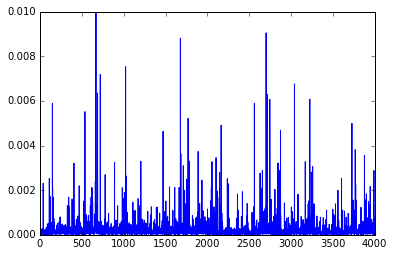

In [20]:
clfRF = RandomForestClassifier(n_estimators=250)
clfRF = clfRF.fit(X=featuresTrain, y=labelsTrain)

plt.plot(clfRF.feature_importances_)

model = SelectFromModel(clfRF, "1.0*mean", prefit=True)
featuresTrainSel = model.transform(featuresTrain)
featuresTestSel = model.transform(featuresTest)
featuresTestSel.shape

In [21]:
clfLR = LogisticRegression(penalty='l2', dual=True, tol=0.0001, C=1, fit_intercept=True, 
                           intercept_scaling=1.0, class_weight=None, random_state=None)
clfLR = clfLR.fit(X=featuresTrainSel, y=labelsTrain)
labelsPred = clfLR.predict(featuresTestSel)
print(classification_report(labelsPred, labelsTest))

             precision    recall  f1-score   support

          0       0.63      0.75      0.68       298
          1       0.26      0.53      0.35        77
          2       0.85      0.66      0.74       614

avg / total       0.73      0.68      0.69       989



In [22]:
clfSGD = SGDClassifier(loss='hinge', penalty='l2', alpha = 3*1e-3, n_iter=5, random_state=42)
clfSGD = clfSGD.fit(X=featuresTrainSel, y=labelsTrain)
labelsPred = clfSGD.predict(featuresTestSel)
print(classification_report(labelsPred, labelsTest))

             precision    recall  f1-score   support

          0       0.51      0.76      0.61       237
          1       0.20      0.58      0.30        53
          2       0.90      0.61      0.73       699

avg / total       0.77      0.65      0.68       989



# Part 4: Ensemble all models
 As discussed by Pedro Domigos (who gives one of my favorist ML course) in his paper: http://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf, it is not about which algorithm is the best, but more about who has more data. Since the data in this example is fixed, it is the question of combining many models. Also, take a closer look at the results of precision and recall for each classifier, their behaviors are rather different. It is a good sign for ensembling where different models can be combined to give better prediction.
 
The simpliest ensemble method is averaging. Here I ensemble the prediction of 16 models presented above by simple averaging. More sophisticated approach such as stacking can be also used. 
 
By this simple ensemble of 16 models, results are improved significantly compared to single model.

In [23]:
tweetsTrain, tweetsTest, labelsTrain, labelsTest = cross_validation.train_test_split(tweets, labels, 
                                                                      train_size=0.85, random_state=1234)
import predict_sentiments as ps
labelsPred = ps.predict_ensemblemodels(tweetsTrain, labelsTrain, tweetsTest)
print(classification_report(labelsPred, labelsTest))

Step 1: Cleaning text 

Step 2: Extracting features 

Step 3: Training classifiers 

For vectorized features ....
counting features ....
stacked features ....
and significant features ....
done! 

Final predictions and ensemble 

             precision    recall  f1-score   support

          0       0.60      0.75      0.67       280
          1       0.23      0.63      0.34        57
          2       0.88      0.64      0.74       652

avg / total       0.76      0.67      0.70       989



# Part 5: Future works
There are still many interesting things to try:
    
    * Deep learning using Recurrent Neural Network: I have tried a bit for this data, but results are not satisfactory. The reason is the size of training samples, which is rather limitted in this example. Also, the topic in the given tweets is varied significantly, also required the amount of training data very large.
    
    * Other ideas such as NBSVM or Paragraph Vector
    
    * More complicated ensemble methods